In [18]:
import numba
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit
import scipy

In [19]:
T=1
R=1
a = 10*R
epsilons = np.linspace(0.1,2.5,50)*R

steps = 100000
nsteps = 100000
dt = T/steps
#initial positions 
r0 = np.array([[0, a*np.sqrt(3)/3],
[a/2, -a*np.sqrt(3)/6],
[-a/2, -a*np.sqrt(3)/6]
])

In [20]:
np.sum(r0,axis=0)

array([0., 0.])

In [21]:
def getAngle(a,b):
    return (180/np.pi)*np.arccos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))




In [51]:
@njit
def getDistanceMatrix(A):
    tiledPoses = tile(A)
    distances = tiledPoses - tiledPoses.transpose((1,0,2))
    return -distances

In [52]:
@njit
def tile(x):
    tiled = np.zeros((3,3,2))
    for i in range(3):
        tiled[i,:,:] = x
        
    return tiled


In [53]:
@njit
def tile2(x):
    tiled = np.zeros((3,3,2,2))
    for i in range(2):
        for j in range(2):
            tiled[:,:,i,j] = x
        
    return tiled

In [62]:
@njit
def getO(d):
    d2 = d**2    
    drNorm = np.sum(d2,axis=2)**0.5
            
    
    I5_5_3_3 = np.zeros((3,3,2,2))

    for i in range(3):
        for j in range(3):
            I5_5_3_3[i,j,:,:] = np.eye(2)


    c1 = d.reshape(3,3,2,1)
    c2 = c1.transpose(0,1,3,2)    
    B = np.multiply(c1,c2)    
    c3 = tile2(drNorm)

    O = R*(I5_5_3_3 + B/(c3**2))*0.75/c3 #*R/norm(l)
    
    

    for i in range(3):  #for i=j
        O[i,i,:,:] = np.eye(2)
    return O

In [73]:
c1 = getDistanceMatrix(r0).reshape(3,3,2,1)
c2 = c1.transpose(0,1,3,2)    
B = np.multiply(c1,c2)    

In [77]:
getDistanceMatrix(r0)[0,1]

array([-5.        ,  8.66025404])

In [75]:
getO

array([[ 25.        , -43.30127019],
       [-43.30127019,  75.        ]])

In [72]:
c3[:,:,1,1] == c3[:,:,1,0]

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [66]:
c3 = tile2(drNorm)
c3.shape

(3, 3, 2, 2)

In [63]:
O = getO(getDistanceMatrix(r0))

(3, 3, 2, 2) (3, 3, 2, 2)


In [56]:
O.shape

(3, 3, 2, 2)

In [57]:
getDistanceMatrix(r0)[0,1]

array([-5.        ,  8.66025404])

In [78]:
newO = np.zeros((6,6))
for i in range(3):
    for j in range(3):
        newO[2*i:2*i+2,2*j:2*j+2] = O[i,j]       
        

In [81]:
np.linalg.det(newO)

0.9219530029487609

In [60]:
getDistanceMatrix(r0).shape

(3, 3, 2)

In [61]:
getDistanceMatrix(r0)[0,1]

array([-5.        ,  8.66025404])

In [32]:
r_cm = np.sum(r0,axis=0)/3
dr = r0-r_cm
dr

array([[ 0.        ,  5.77350269],
       [ 5.        , -2.88675135],
       [-5.        , -2.88675135]])

In [101]:
np.round(np.matmul(np.linalg.inv(newO),newO))

array([[ 1.,  0., -0.,  0., -0., -0.],
       [-0.,  1.,  0., -0., -0., -0.],
       [-0.,  0.,  1.,  0., -0.,  0.],
       [-0.,  0., -0.,  1.,  0.,  0.],
       [ 0.,  0.,  0., -0.,  1., -0.],
       [ 0., -0.,  0., -0.,  0.,  1.]])

In [33]:
@njit
def getA(r):
   

    d = getDistanceMatrix(r)
    
    r_cm = np.sum(r,axis=0)/3
    dr = r-r_cm
    



    A1_2 = np.array([
    
    [0, 0,    0, 0,     0, 0,                    1, 0,    1, 0,    1, 0],
    [0, 0,    0, 0,    0, 0,                     0, 1,    0, 1,    0, 1]]
)
        
    A3_6 = np.array([
    
    [0, 0,    0, 0,     0, 0,               r[0,1], -r[0,0] ,      r[1,1], -r[1,0] , r[2,1], -r[2,0] ],

    [d[1,0,0], d[1,0,1],      -d[1,0,0], -d[1,0,1],     0, 0,       0, 0,    0, 0,    0, 0],
    [d[2,0,0], d[2,0,1],     0, 0,     -d[2,0,0], -d[2,0,1],    0, 0,  0, 0,  0, 0],   
    [0,0,    d[2,1,0], d[2,1,1],  d[2,1,0], d[2,1,1],       0, 0,    0, 0,    0, 0],
    

    ])

    

    O = getO(d)
    newO = np.zeros((6,6))
    for i in range(3):
        for j in range(3):
            newO[2*i:2*i+2,2*j:2*j+2] = O[i,j]

    A6_12  = np.concatenate((-np.eye(6),newO),axis=1)
#     
# # 
# # # A16 = [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,     O1_1[1_1], O1_1[1_2], O1_1[1_3], O1_2, O1_3, O1_4, O1_5]
# # # A17 = [0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,      O1_1[2_1], O1_1[2_2], O1_1[2_3], O1_2, O1_3, O1_4, O1_5]
# # # A18 = [0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,    O1_1[3_1], O1_1[3_2], O1_1[3_3], O1_2, O1_3, O1_4, O1_5]
# # 
    A = np.concatenate((A1_2,A3_6,A6_12),axis=0)
    return A

In [93]:
for i in range(12):
    for j in range(i+1,12):
        print(i,j,np.dot(A[:,i],A[:,j])/(np.linalg.norm(A[:,i])*np.linalg.norm(A[:,i])))

0 1 0.0
0 2 -0.4901960784313725
0 3 0.8490445135141552
0 4 -0.4901960784313725
0 5 -0.8490445135141552
0 6 -0.019607843137254898
0 7 0.0
0 8 -0.0018382352941176468
0 9 0.0006367833851356165
0 10 -0.0018382352941176468
0 11 -0.0006367833851356165
1 2 0.2867633787365691
1 3 -0.4966887417218543
1 4 -0.2867633787365691
1 5 -0.4966887417218543
1 6 0.0
1 7 -0.006622516556291392
1 8 0.00021507253405242684
1 9 -0.0008692052980132452
1 10 -0.00021507253405242684
1 11 -0.0008692052980132452
2 3 -0.34366087451763433
2 4 0.7936507936507936
2 5 0.0
2 6 -0.000744047619047619
2 7 0.00025774565588822576
2 8 -0.007936507936507936
2 9 0.0
2 10 -0.0011904761904761904
2 11 0.0
3 4 0.0
3 5 0.0
3 6 0.00042731516634100596
3 7 -0.0017269736842105267
3 8 0.0
3 9 -0.013157894736842108
3 10 0.0
3 11 -0.0009868421052631581
4 5 0.34366087451763433
4 6 -0.000744047619047619
4 7 -0.00025774565588822576
4 8 -0.0011904761904761904
4 9 0.0
4 10 -0.007936507936507936
4 11 0.0
5 6 -0.00042731516634100596
5 7 -0.001726973

In [95]:
np.linalg.det(A)

-1.8265792477265983e-12

In [35]:
A = getA(r0)
A 

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   1.        ,   0.        ,
          1.        ,   0.        ,   1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   1.        ,
          0.        ,   1.        ,   0.        ,   1.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   5.77350269,  -0.        ,
         -2.88675135,  -5.        ,  -2.88675135,   5.        ],
       [  5.        ,  -8.66025404,  -5.        ,   8.66025404,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ -5.        ,  -8.66025404,   0.        ,   0.        ,
          5.        ,   8.66025404,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,

In [36]:
A[6:12,6:12]

array([[ 1.        ,  0.        ,  0.09375   , -0.03247595,  0.09375   ,
         0.03247595],
       [ 0.        ,  1.        , -0.03247595,  0.13125   ,  0.03247595,
         0.13125   ],
       [ 0.09375   , -0.03247595,  1.        ,  0.        ,  0.15      ,
         0.        ],
       [-0.03247595,  0.13125   ,  0.        ,  1.        ,  0.        ,
         0.075     ],
       [ 0.09375   ,  0.03247595,  0.15      ,  0.        ,  1.        ,
         0.        ],
       [ 0.03247595,  0.13125   ,  0.        ,  0.075     ,  0.        ,
         1.        ]])

In [40]:
np.linalg.det(A)

-1.8265792477265983e-12

In [38]:
np.linalg.solve(A[:6,:6],np.eye(6))

LinAlgError: Singular matrix

In [39]:
A[:6,:6]

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  5.        ,  -8.66025404,  -5.        ,   8.66025404,
          0.        ,   0.        ],
       [ -5.        ,  -8.66025404,   0.        ,   0.        ,
          5.        ,   8.66025404],
       [  0.        ,   0.        , -10.        ,  -0.        ,
        -10.        ,  -0.        ]])

In [11]:

@njit
def getC(l,u):
    lu = np.zeros(3)
    for i in range(3):
        lu[i]= (l[i]*u[i])
        
    
    return np.array([0,0,0,  *list(lu),    0,0,0, 0,0,0])  #not 1

In [12]:
w

NameError: name 'w' is not defined

In [45]:

def getV(r,l,u):
    A = getA(r)
    C = getC(l,u)
    print(A)
    # return np.linalg.solve(A,C)[:6]
    return A,C


In [25]:
@njit
def step(r,L,U):
    #zs = []
    for t in range(nsteps):
        v = getV(r,L[:,t],U).reshape((3,2))
        
        r += dt*v
     #   zs.append(r[0,0])
        
        
    return r
        

In [26]:
def visualize(r,angles=(0,0)):
    colors = ('r', 'g', 'b')

    
    plt.xlim((-10,10))
    plt.ylim((-10,10))
    plt.plot([r[1,0] , r[0,0]] ,  [r[1,1] , r[0,1]] ,c="b")
    plt.plot([r[2,0] , r[0,0]] , [r[2,1] , r[0,1]] ,c="b")
    plt.plot( [r[2,0] , r[1,0]] ,  [r[2,1] , r[1,1]] ,c="b")

    plt.scatter(x = r[:,0],y = r[:,1] ,c=colors,s=100)
    

    plt.show()
    

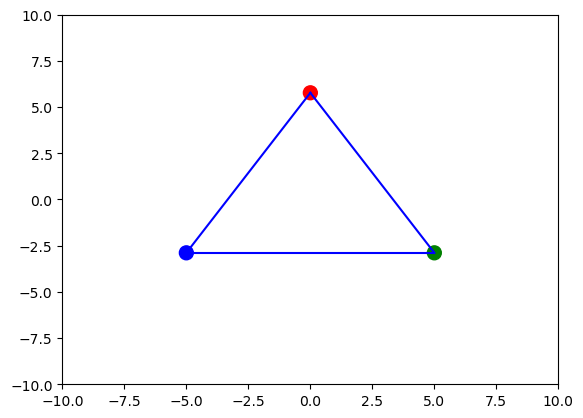

In [27]:
visualize(r0)

In [28]:
@njit
def act(r,L,U):
    r_final = step(r.copy(),L,U)
    delta = list(np.sum(r_final,axis=0)-np.sum(r,axis=0))
    
    
    dPhi = getPhi(r_final) - getPhi(r)
    
    return r_final,np.array([*delta,dPhi])

In [29]:
@njit
def getPhi(r):
    c = r[0] - np.sum(r,axis =0)
    return (180/np.pi)*np.arctan(c[0]/c[1])

In [18]:
rf1,_ =  act(r0,np.array([closing,opened,opened]),np.array([-w,0,0]))


NameError: name 'closing' is not defined

In [22]:
w

4.0

In [46]:
L,U = np.array([closing,opened,opened]),np.array([-w,0,0])
A,C = getV(r0,L[:,0],U)

[[ 0.          0.          0.          0.          0.          0.
   1.          0.          1.          0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.          0.          1.          0.          1.        ]
 [ 0.          0.          0.          0.          0.          0.
   5.77350269 -0.         -2.88675135 -5.         -2.88675135  5.        ]
 [-5.          8.66025404  5.         -8.66025404  0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 5.          8.66025404  0.          0.         -5.         -8.66025404
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.         10.          0.         10.          0.
   0.          0.          0.          0.          0.          0.        ]
 [-1.         -0.         -0.         -0.         -0.         -0.
   1.          0.          0.09375    -0.03247595  0.09375     0.03247595]
 [-0.

In [54]:
np.matmul(np.flipud(A),C)[:6]

array([ 0.,  0., 40.,  0.,  0.,  0.])

In [62]:
np.matmul(A,np.flipud(A))

array([[-5.00000000e+00,  8.66025404e+00,  1.50000000e+01,
        -8.66025404e+00,  1.00000000e+01,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 5.00000000e+00,  8.66025404e+00,  0.00000000e+00,
         0.00000000e+00, -5.00000000e+00, -8.66025404e+00,
         6.77350269e+00,  0.00000000e+00, -1.88675135e+00,
        -5.00000000e+00, -1.88675135e+00,  5.00000000e+00],
       [ 1.44337567e+01, -2.50000000e+01,  4.33012702e+01,
         2.50000000e+01,  5.77350269e+01,  0.00000000e+00,
        -2.38675135e+01, -2.88675135e+00,  1.94337567e+01,
         2.21132487e+01,  1.94337567e+01, -2.78867513e+01],
       [ 0.00000000e+00,  0.00000000e+00,  8.66025404e+00,
        -5.00000000e+00, -8.66025404e+00,  5.00000000e+00,
        -3.24759526e-01,  5.62500000e-01, -7.36121593e+00,
         4.62500000e+00,  7.36121593e+00, -4.62500000e+00],
       [ 8.66025404e+00,  5.00000000e+00,  0.0000000

In [59]:
np.flipud(A).shape

(12, 12)

In [60]:
A.shape

(12, 12)

In [19]:
data0 = np.zeros((50,3))
for i in range(50):
    epsilon = epsilons[i]



    w = epsilon/T


    print(epsilon)




    closing  = a - np.arange(steps)*epsilon/steps
    opening = a - epsilon + np.arange(steps)*epsilon/steps
    opened = a *np.ones(steps)
    closed = (a-epsilon)*np.ones(steps)
    
    
    rf1,change=  act(r0,np.array([closing,opened,opened]),np.array([-w,0,0]))
    data0[i,:] = change

    

0.1
0.1489795918367347
0.19795918367346937
0.24693877551020407
0.29591836734693877


SystemError: CPUDispatcher(<function act at 0x7f4b17d5ac00>) returned a result with an exception set

In [151]:
data0[:,1]

array([4.81657260e+08, 7.17571021e+08, 9.53484781e+08, 1.18939854e+09,
       1.42531230e+09, 1.66122606e+09, 1.89713982e+09, 2.13305358e+09,
       2.36896734e+09, 2.60488110e+09, 2.84079486e+09, 3.07670862e+09,
       3.31262238e+09, 3.54853614e+09, 3.78444990e+09, 4.02036366e+09,
       4.25627742e+09, 4.49219118e+09, 4.72810494e+09, 4.96401870e+09,
       5.19993246e+09, 5.43584622e+09, 5.67175998e+09, 5.90767374e+09,
       6.14358750e+09, 6.37950126e+09, 6.61541502e+09, 6.85132878e+09,
       7.08724254e+09, 7.32315631e+09, 7.55907007e+09, 7.79498383e+09,
       8.03089759e+09, 8.26681135e+09, 8.50272511e+09, 8.73863887e+09,
       8.97455263e+09, 9.21046639e+09, 9.44638015e+09, 9.68229391e+09,
       9.91820767e+09, 1.01541214e+10, 1.03900352e+10, 1.06259489e+10,
       1.08618627e+10, 1.10977765e+10, 1.13336902e+10, 1.15696040e+10,
       1.18055177e+10, 1.20414315e+10])

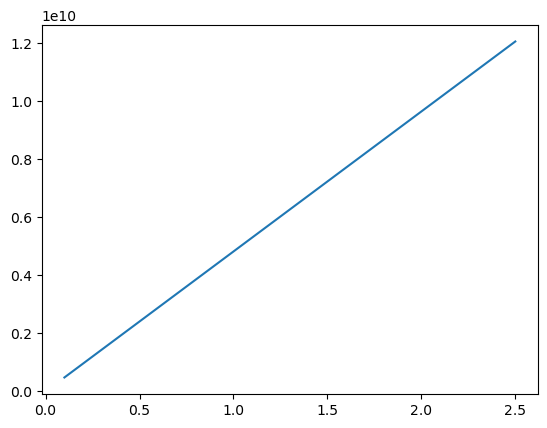

In [152]:
plt.plot(epsilons,data0[:,1])

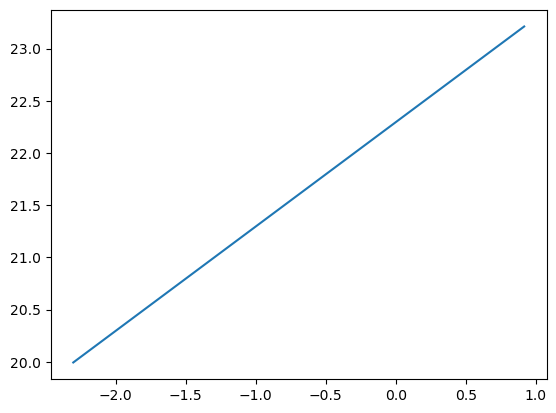

In [153]:
plt.plot(np.log(epsilons),np.log(data0[:,1]))

4


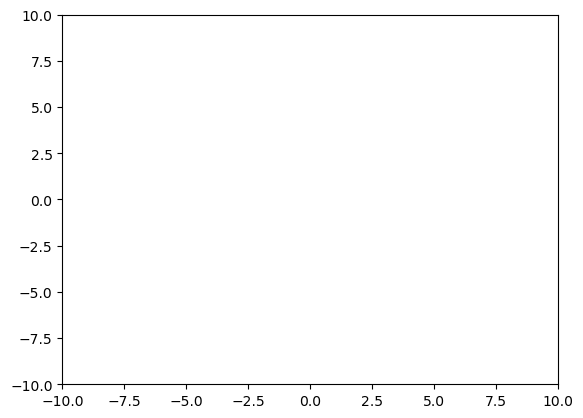

227984436564.00656 227984436564.0065 394881524112.79834


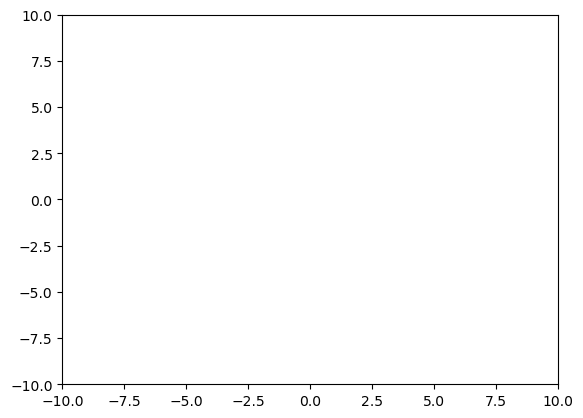

227984436653.63647 227984436653.63644 394886526608.4164


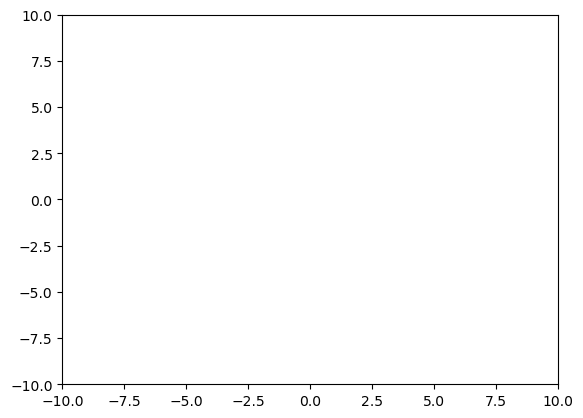

227984436654.76 227984436654.75998 394888032471.2076


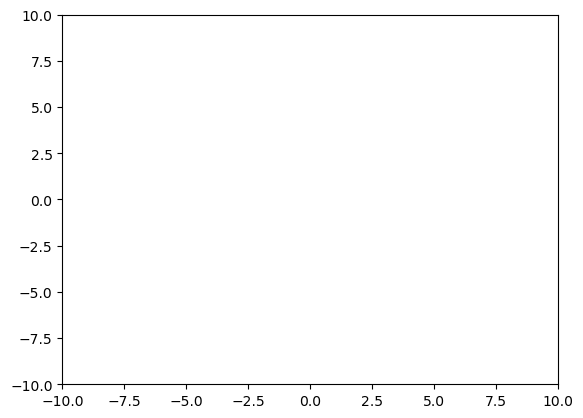

227984436655.34668 227984436655.3466 394888698305.8651


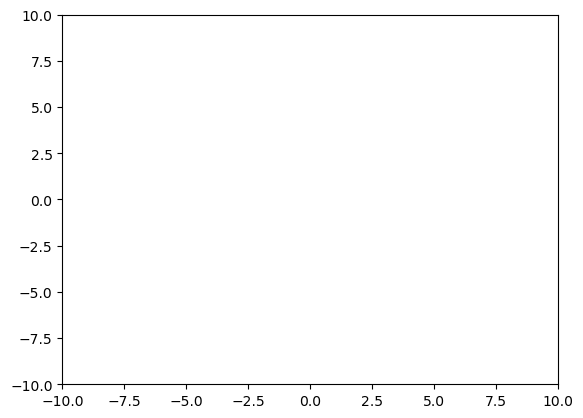

227984436659.30817 227984436659.30814 394888607154.83215


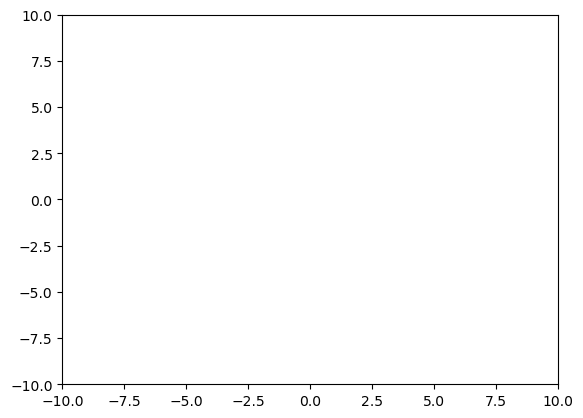

227984436659.86185 227984436659.86182 394888722141.6616


In [20]:
epsilon = 4



w = epsilon/T


print(epsilon)




closing  = a - np.arange(steps)*epsilon/steps
opening = a - epsilon + np.arange(steps)*epsilon/steps
opened = a *np.ones(steps)
closed = (a-epsilon)*np.ones(steps)
    
    
  
    
    


    
rf1,_ =  act(r0,np.array([closing,opened,opened]),np.array([-w,0,0]))
visualize(rf1)   
print(np.linalg.norm(rf1[1]-rf1[0]),   np.linalg.norm(rf1[2]-rf1[0])   ,  np.linalg.norm(rf1[2]-rf1[1]))


rf2,_ =  act(rf1,np.array([closed,closing,opened]),np.array([0,-w,0]))
visualize(rf2)
print(np.linalg.norm(rf2[1]-rf2[0]),   np.linalg.norm(rf2[2]-rf2[0])   ,  np.linalg.norm(rf2[2]-rf2[1]))


rf3,_ =  act(rf2,np.array([closed,closed,closing]),np.array([0,0,-w]))
visualize(rf3)
print(np.linalg.norm(rf3[1]-rf3[0]),   np.linalg.norm(rf3[2]-rf3[0])   ,  np.linalg.norm(rf3[2]-rf3[1]))



rf4,_ =  act(rf3,np.array([opening,closed,closed]),np.array([w,0,0]))
visualize(rf4)
print(np.linalg.norm(rf4[1]-rf4[0]),   np.linalg.norm(rf4[2]-rf4[0])   ,  np.linalg.norm(rf4[2]-rf4[1]))



rf5,_ =  act(rf4,np.array([opened,opening,closed]),np.array([0,w,0]))
visualize(rf5)
print(np.linalg.norm(rf5[1]-rf5[0]),   np.linalg.norm(rf5[2]-rf5[0])   ,  np.linalg.norm(rf5[2]-rf5[1]))



rf6,change =  act(rf5,np.array([opened,opened,opening]),np.array([0,0,w]))
visualize(rf6)
print(np.linalg.norm(rf6[1]-rf6[0]),   np.linalg.norm(rf6[2]-rf6[0])   ,  np.linalg.norm(rf6[2]-rf6[1]))

    
    
    
    
 


In [122]:
change

array([-9.40804433e-04,  2.12569563e-03,  2.81750121e+01])

In [237]:
def getAngle(a,b):
    return (180/np.pi)*np.arccos(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)))


getAngle(rf2[1]-rf2[0],rf2[4]-rf2[0])

109.47122063452433

In [238]:
data = np.zeros((8,5,50))
for i in range(50):
    
    epsilon = epsilons[i]



    w = epsilon/T


    print(epsilon)




    closing  = a - np.arange(steps)*epsilon/steps
    opening = a - epsilon + np.arange(steps)*epsilon/steps
    opened = a *np.ones(steps)
    closed = (a-epsilon)*np.ones(steps)
    
    
    a2 = a -epsilon
    
    
  
    r0 = np.array([[0, 0, 0],
    [0, 0, a2],
    [a2*np.sqrt(8)/3, 0 , -a2/3],
    [-a2*np.sqrt(8)/6, a2*np.sqrt(24)/6 , -a2/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    

    _,data[0,:,i] = act(r0,np.array([opening,closed,closed,closed]),np.array([w,0,0,0]))
    
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a],
    [a2*np.sqrt(8)/3, 0 , -a2/3],
    [-a2*np.sqrt(8)/6, a2*np.sqrt(24)/6 , -a2/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    
    
    _,data[1,:,i] = act(r0,np.array([closing,closed,closed,closed]),np.array([-w,0,0,0]))
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a2],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a2*np.sqrt(8)/6, a2*np.sqrt(24)/6 , -a2/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    
    
    
    _,data[2,:,i] = act(r0,np.array([opening,opened,closed,closed]),np.array([w,0,0,0]))
    
    
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a2*np.sqrt(8)/6, a2*np.sqrt(24)/6 , -a2/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    
    _,data[3,:,i] = act(r0,np.array([closing,opened,closed,closed]),np.array([-w,0,0,0]))
    
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a2],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    
    
    _,data[4,:,i] = act(r0,np.array([opening,opened,opened,closed]),np.array([w,0,0,0]))
    
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
    [-a2*np.sqrt(8)/6, -a2*np.sqrt(24)/6, -a2/3]])
    
    _,data[5,:,i] = act(r0,np.array([closing,opened,opened,closed]),np.array([w,0,0,0]))

    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a2],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
    [-a*np.sqrt(8)/6, -a*np.sqrt(24)/6, -a/3]])
    
    _,data[6,:,i] = act(r0,np.array([opening,opened,opened,opened]),np.array([-w,0,0,0]))
    
    
    
    
    r0 = np.array([[0, 0, 0],
    [0, 0, a],
    [a*np.sqrt(8)/3, 0 , -a/3],
    [-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
    [-a*np.sqrt(8)/6, -a*np.sqrt(24)/6, -a/3]])
    
    _,data[7,:,i] = act(r0,np.array([closing,opened,opened,opened]),np.array([w,0,0,0]))
    
    # rf,_ =  act(r0,np.array([closing,opened,opened,opened]),np.array([-w,0,0,0]))
    # 
    # rf,_ =  act(rf,np.array([closed,closing,opened,opened]),np.array([0,-w,0,0]))
    # 
    # rf,_ =  act(rf,np.array([closed,closed,closing,opened]),np.array([0,0,-w,0]))
    # 
    # rf,_ =  act(rf,np.array([opening,closed,closed,opened]),np.array([w,0,0,0]))
    # 
    # rf,_ =  act(rf,np.array([opened,opening,closed,opened]),np.array([0,w,0,0]))
    # 
    # rf,change =  act(rf,np.array([opened,opened,opening,opened]),np.array([0,0,w,0]))
    # visualize(rf)
    # 
    # data[i,:] = change
    
    
    
 


    


#save data

0.1
0.1489795918367347
0.19795918367346937
0.24693877551020407
0.29591836734693877
0.3448979591836735
0.3938775510204081
0.44285714285714284
0.49183673469387756
0.5408163265306122
0.5897959183673469
0.6387755102040816
0.6877551020408162
0.736734693877551
0.7857142857142857
0.8346938775510203
0.883673469387755
0.9326530612244898
0.9816326530612244
1.030612244897959
1.079591836734694
1.1285714285714286
1.1775510204081634
1.226530612244898
1.2755102040816326
1.3244897959183675
1.373469387755102
1.4224489795918367
1.4714285714285715
1.5204081632653061
1.5693877551020408
1.6183673469387756
1.6673469387755102
1.7163265306122448
1.7653061224489797
1.8142857142857143
1.863265306122449
1.9122448979591837
1.9612244897959183
2.010204081632653
2.059183673469388
2.1081632653061226
2.157142857142857
2.206122448979592
2.2551020408163267
2.304081632653061
2.353061224489796
2.4020408163265308
2.451020408163265
2.5


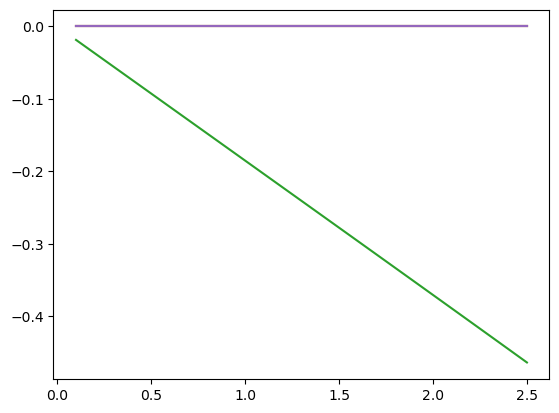

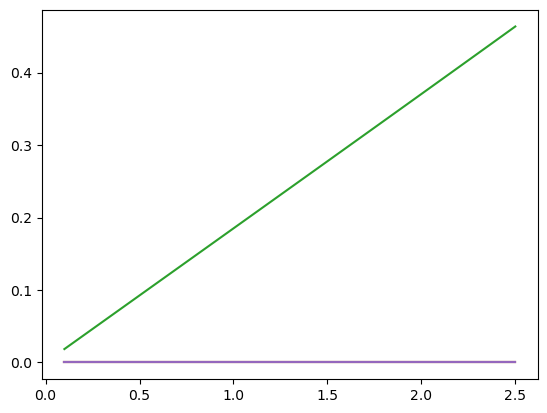

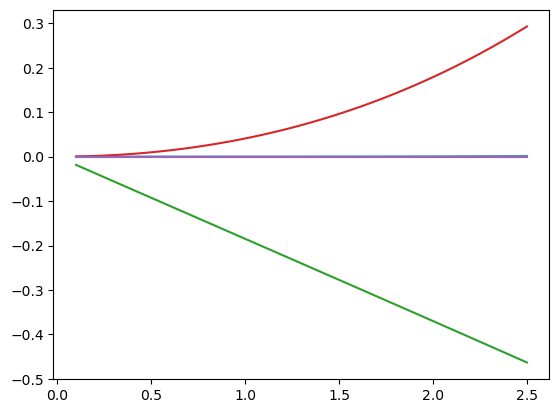

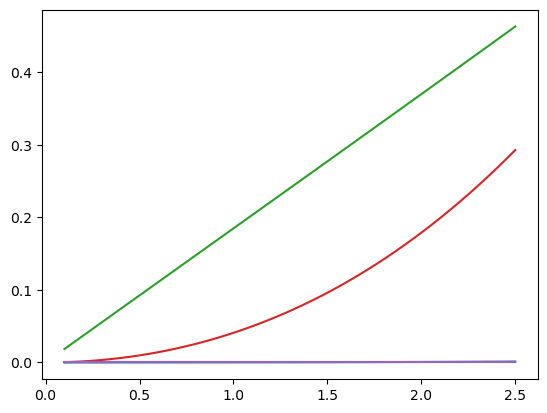

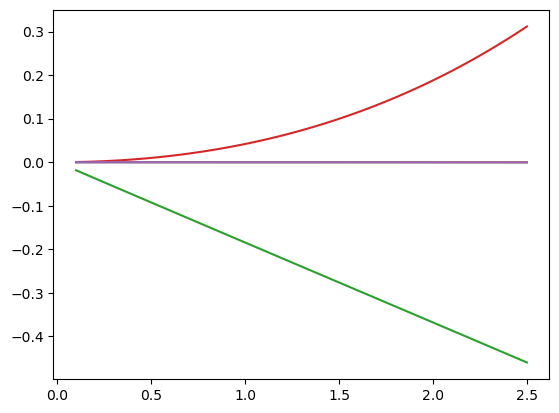

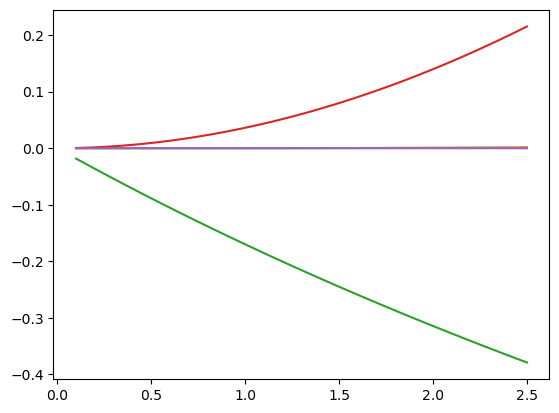

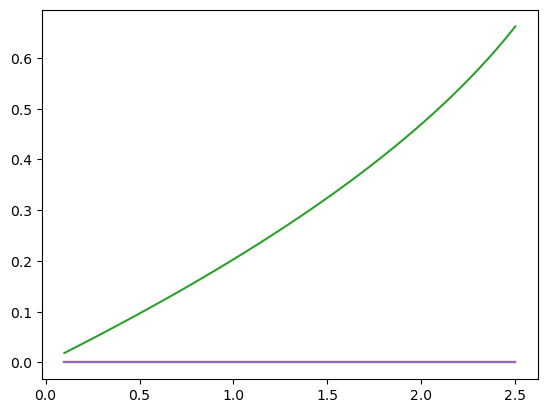

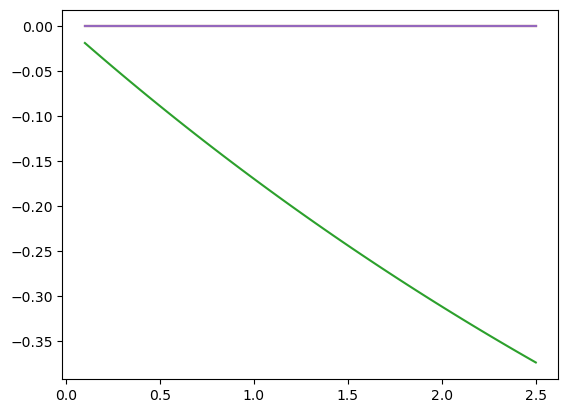

In [239]:
for i in range(8):
    for j in range(5):
        plt.plot(epsilons,data[i,j,:])
    plt.show()

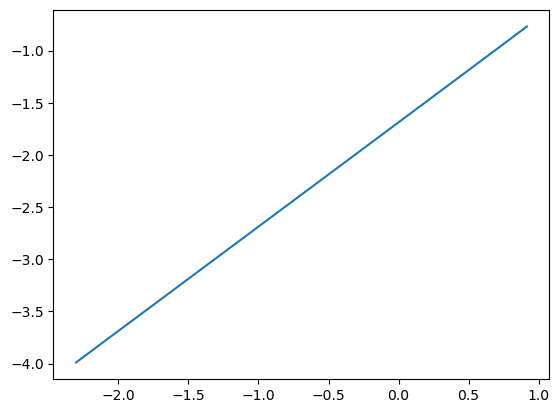

1.0004317841418426


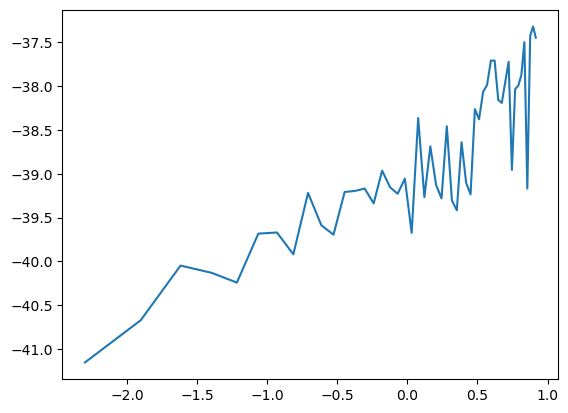

0.9864845838550458


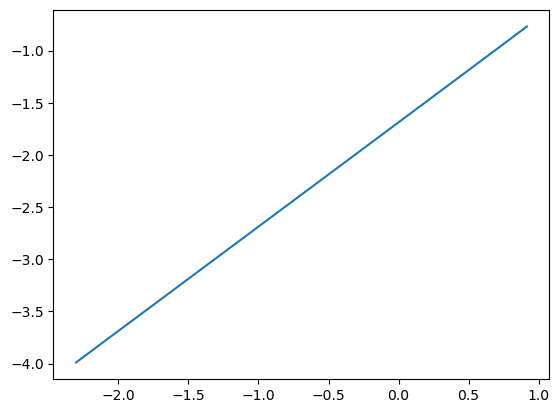

1.0004319635217922


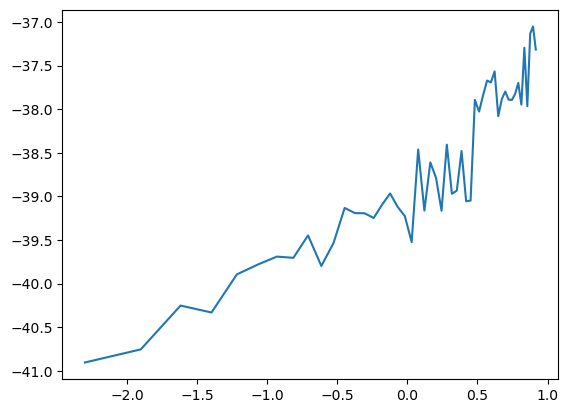

1.1218663668741853


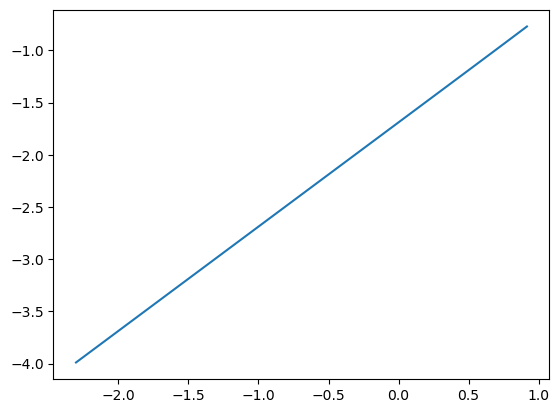

0.9998026229942921


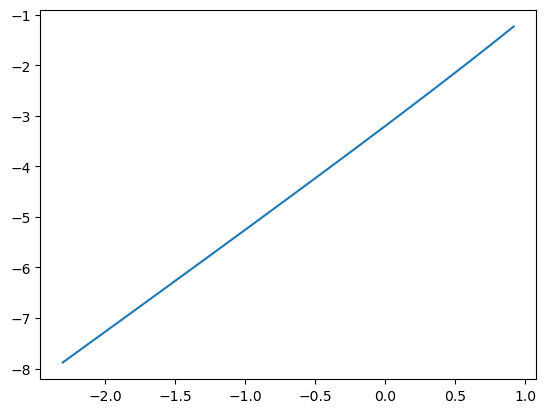

2.075321933899558


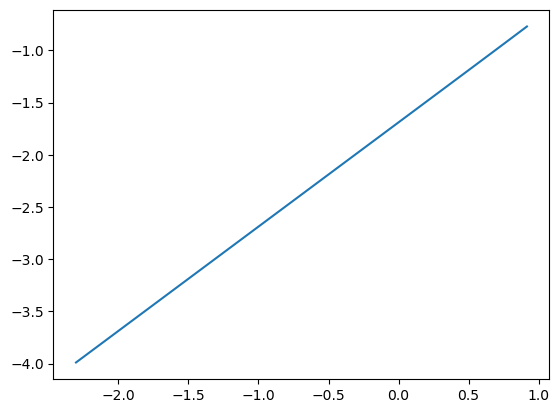

0.999802239159984


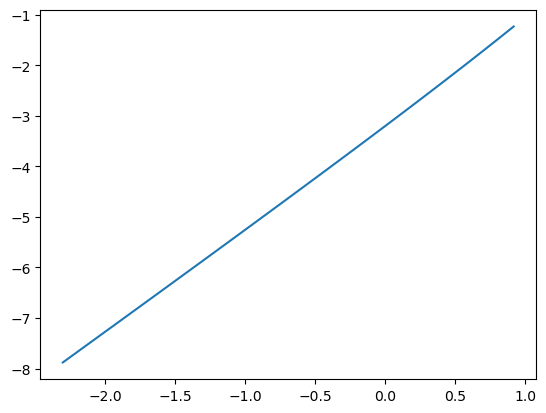

2.0753234535698932


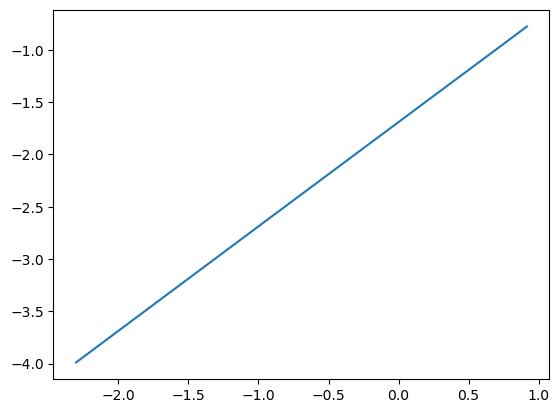

0.997452130325103


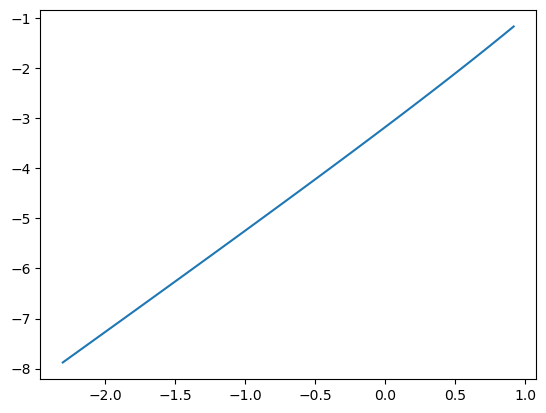

2.096252608010849


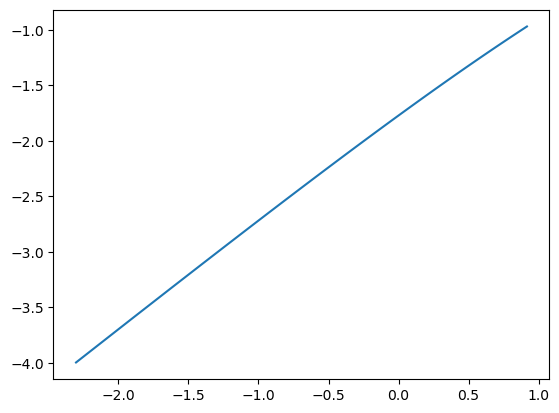

0.932040042865642


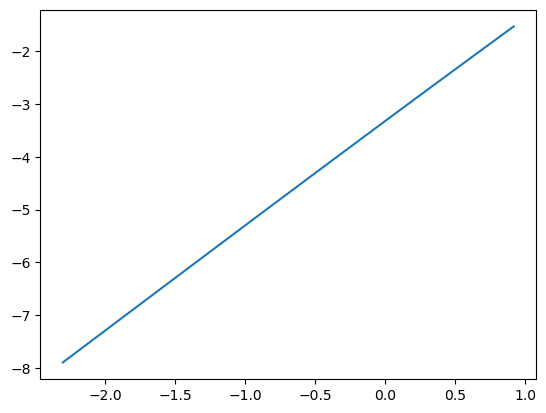

1.971222392086489


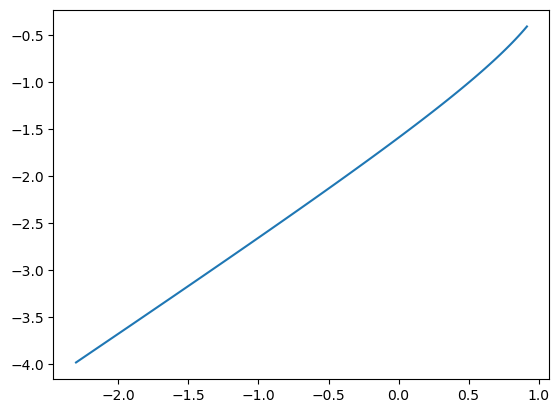

1.1107124011479481


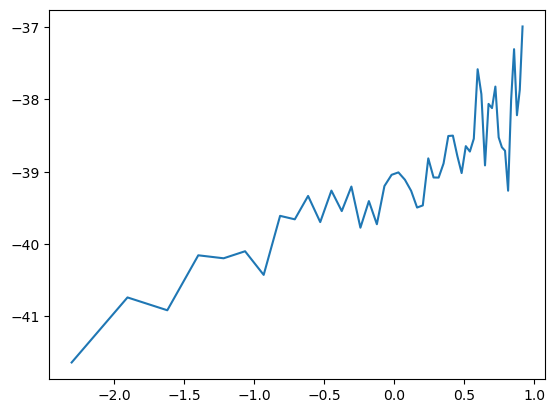

1.0380887466798225


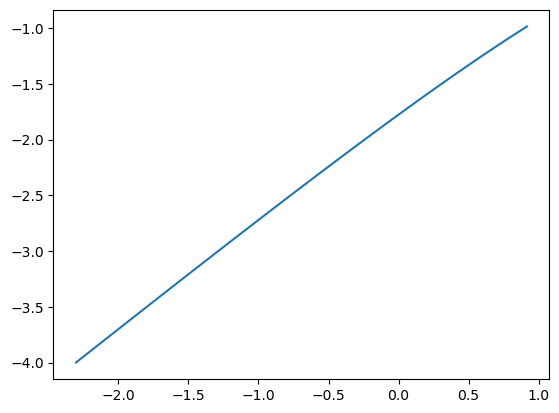

0.9272150992068434


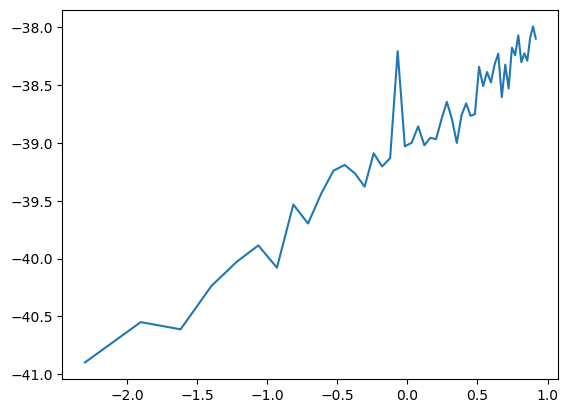

0.8791335212664455


In [288]:
for i in range(8):
    plt.plot(np.log(epsilons),np.log(np.abs(data[i,2,:])))
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(epsilons[:]),np.log(np.abs(data[i,2,:])))
    print(slope)
    
    
    plt.plot(np.log(epsilons),np.log(np.abs(data[i,3,:])))
    plt.show()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log(epsilons[:]),np.log(np.abs(data[i,3,:])))
    print(slope)
    
    

    
    


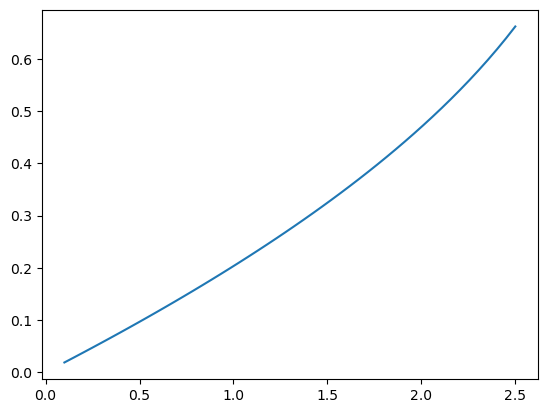

In [275]:
plt.plot(epsilons,data[6,2,:])

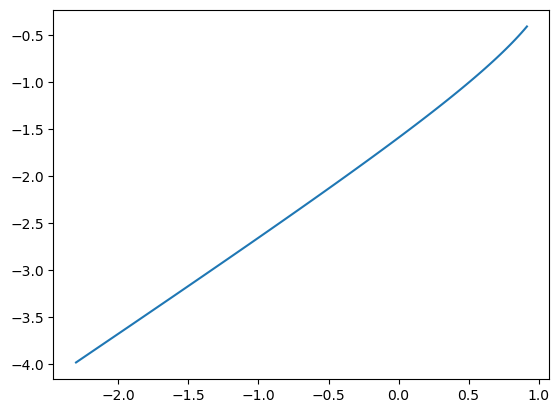

In [276]:
plt.plot(np.log(epsilons[:]),np.log(data[6,2,:]))


In [128]:
data2 = np.zeros((3,50))
for i in range(50):
    
    epsilon = epsilons[i]



    w = epsilon/T


    print(epsilon)




    closing  = a - np.arange(steps)*epsilon/steps
    opening = a - epsilon + np.arange(steps)*epsilon/steps
    opened = a *np.ones(steps)
    closed = (a-epsilon)*np.ones(steps)
    
    
    
    rf,_ =  act(r0,np.array([closing,opened,opened]),np.array([-w,0,0]))

    rf,_ =  act(rf,np.array([closed,closing,opened]),np.array([0,-w,0]))

    rf,_ =  act(rf,np.array([closed,closed,closing]),np.array([0,0,-w]))
    
    rf,_ =  act(rf,np.array([opening,closed,closed]),np.array([w,0,0]))


    rf,_ =  act(rf,np.array([opened,opening,closed,closed]),np.array([0,w,0]))
    
    rf,change =  act(rf,np.array([opened,opened,opening]),np.array([0,0,w]))

    #visualize(rf)

    data2[:,i] = change
    
    
    
 


    


#save data

0.1
0.1489795918367347
0.19795918367346937
0.24693877551020407
0.29591836734693877
0.3448979591836735
0.3938775510204081
0.44285714285714284
0.49183673469387756
0.5408163265306122
0.5897959183673469
0.6387755102040816
0.6877551020408162
0.736734693877551
0.7857142857142857
0.8346938775510203
0.883673469387755
0.9326530612244898
0.9816326530612244
1.030612244897959
1.079591836734694
1.1285714285714286
1.1775510204081634
1.226530612244898
1.2755102040816326
1.3244897959183675
1.373469387755102
1.4224489795918367
1.4714285714285715
1.5204081632653061
1.5693877551020408
1.6183673469387756
1.6673469387755102
1.7163265306122448
1.7653061224489797
1.8142857142857143
1.863265306122449
1.9122448979591837
1.9612244897959183
2.010204081632653
2.059183673469388
2.1081632653061226
2.157142857142857
2.206122448979592
2.2551020408163267
2.304081632653061
2.353061224489796
2.4020408163265308
2.451020408163265
2.5


IndexError: list index out of range

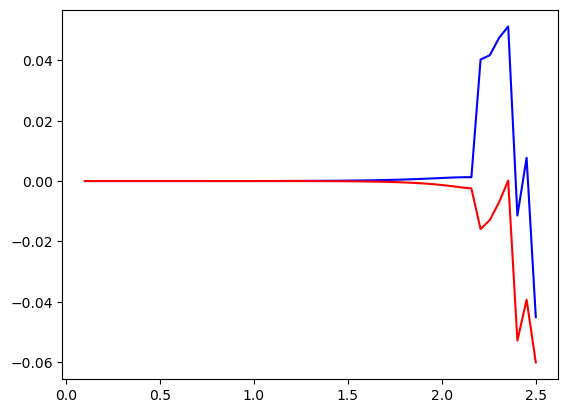

In [130]:
colors = ["b","r"]
for i in range(3):
    plt.plot(epsilons,data2[i],c=colors[i])
    

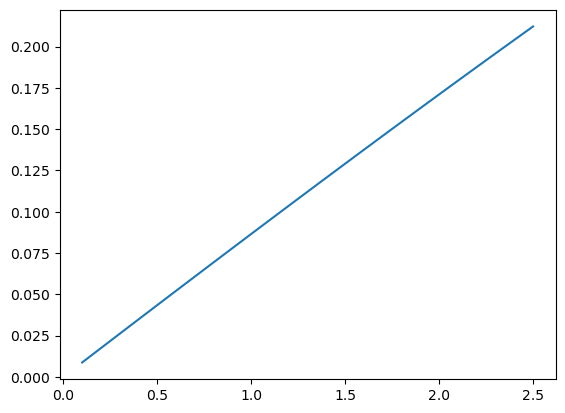

In [295]:
plt.plot(epsilons,data2[])